In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Guadalajara hexagon grid

In [2]:
type = "urban"
city = "Guadalajara"
query_urban = f"SELECT * FROM hexgrid.hexgrid_8_city_2020 WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{type}\'"
query_urban

'SELECT * FROM hexgrid.hexgrid_8_city_2020 WHERE "city" LIKE \'Guadalajara\' AND "type" LIKE \'urban\''

In [3]:
hex_gdf = aup.gdf_from_query(query_urban, geometry_col='geometry')
print(hex_gdf.shape)
hex_gdf.head(2)

(1132, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,88498c9421fffff,"POLYGON ((-103.28663 20.69309, -103.28209 20.6...",14039,Guadalajara,Guadalajara,urban
1,88498c9405fffff,"POLYGON ((-103.30025 20.68392, -103.29571 20.6...",14039,Guadalajara,Guadalajara,urban


## Edges and nodes

In [4]:
G, nodes, edges = aup.graph_from_hippo(hex_gdf, schema='osmnx', edges_folder='edges_elevation_23_line', nodes_folder='nodes_osmnx_23_point') 

In [5]:
nodes = nodes.reset_index()
nodes.head(2)

,osmid,x,y,street_count,geometry,city
0,28791285,-103.386947,20.674579,3,POINT (-103.38695 20.67458),Guadalajara
1,1363860294,-103.382580,20.629876,3,POINT (-103.38258 20.62988),Guadalajara


In [6]:
edges = edges.reset_index()
edges.head(2)

,u,v,key,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,bridge,maxspeed,ref,access,junction,service,tunnel,width
0,1774344156,1827050267,0,782694623,False,Calle Santa Rosa,residential,70.113,"LINESTRING (-103.32081 20.56605, -103.32112 20...",-0.014,0.014,None,None,None,None,None,None,None,None,None
1,1774344156,6511605645,0,"[473698618, 693569732]",False,"['Privada San Diego', 'Calle Puerto Escondido']",residential,199.626,"LINESTRING (-103.32081 20.56605, -103.32191 20...",-0.005,0.005,None,None,None,None,None,None,None,None,None


In [7]:
edges_var = edges.copy()
edges_var = edges_var.reset_index()
edges_var = edges_var.to_crs("EPSG:32613")
edges_var = edges_var[['u','v','key','osmid','grade_abs','geometry']]

## NDVI

In [9]:
hex_schema = "raster_analysis"
hex_schema_pob = "hexgrid"
hex_tablee = "ndvi_analysis_hex"
ndvi = "ndvi"
hex_id = "hex_id"

query = "SELECT * FROM raster_analysis.ndvi_analysis_hex WHERE city IN ('Guadalajara') AND res = 11";

intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(3)

,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8b49aa24c78bfff,"POLYGON ((-103.52481 20.48558, -103.52464 20.4...",11,0.391447,0.193097,0.358138,0.676304,0.177307,0.498997,-0.003090,Guadalajara
1,8b498c92542bfff,"POLYGON ((-103.20743 20.52515, -103.20726 20.5...",11,0.366426,0.194361,0.319899,0.669227,0.163555,0.505672,-0.002425,Guadalajara
2,8b498c920900fff,"POLYGON ((-103.19685 20.52231, -103.19668 20.5...",11,0.375274,0.234457,0.327169,0.719626,0.133637,0.585989,-0.002394,Guadalajara


In [23]:
edges.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'lanes', 'name', 'highway',
       'maxspeed', 'length', 'geometry', 'bridge', 'ref', 'junction', 'tunnel',
       'access', 'width', 'service', 'city'],
      dtype='object')

In [26]:
edges = edges[["u", "v", "key", "geometry", "osmid"]]
edges

,u,v,key,geometry,osmid
0,4303977502,4303977514,0,"LINESTRING (-103.50987 20.45796, -103.51121 20...",431149558
1,4303977503,4303977514,0,"LINESTRING (-103.51136 20.45798, -103.51121 20...",431149502
2,4303977508,4303977503,0,"LINESTRING (-103.51195 20.45817, -103.51136 20...",431149546
3,4303977517,4303977508,0,"LINESTRING (-103.51292 20.45849, -103.51195 20...",431149546
4,4303977519,4303977505,0,"LINESTRING (-103.51055 20.45850, -103.51005 20...",431149521
...,...,...,...,...,...
414631,8669578133,8432758360,0,"LINESTRING (-103.38285 20.52314, -103.38289 20...",908170488
414632,8753025784,1754556621,0,"LINESTRING (-103.38244 20.52586, -103.38216 20...",163775733
414633,8760908969,6142976278,0,"LINESTRING (-103.38288 20.52434, -103.38289 20...",908170483
414634,8776316843,1754154719,0,"LINESTRING (-103.38176 20.51301, -103.38179 20...",163737788


In [25]:
# Hacer la unión espacial para asignar valores NDVI a edges
edges_ndvi = gpd.overlay(edges, intt_gdl, how='intersection')
edges_ndvi

,u,v,key,osmid,hex_id,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,geometry
0,4303977502,4303977514,0,431149558,8b49aa241891fff,11,0.195943,0.075429,0.180098,0.323646,0.129969,0.193677,-0.001444,Guadalajara,"LINESTRING (-103.50987 20.45796, -103.51020 20..."
1,4303977499,4303977502,0,901369700,8b49aa241891fff,11,0.195943,0.075429,0.180098,0.323646,0.129969,0.193677,-0.001444,Guadalajara,"LINESTRING (-103.50999 20.45764, -103.50987 20..."
2,4303977500,4303977502,0,901369702,8b49aa241891fff,11,0.195943,0.075429,0.180098,0.323646,0.129969,0.193677,-0.001444,Guadalajara,"LINESTRING (-103.50975 20.45792, -103.50987 20..."
3,4303977502,4303977500,0,901369702,8b49aa241891fff,11,0.195943,0.075429,0.180098,0.323646,0.129969,0.193677,-0.001444,Guadalajara,"LINESTRING (-103.50987 20.45796, -103.50975 20..."
4,4303977502,4303977514,0,431149558,8b49aa24189cfff,11,0.197946,0.064450,0.192076,0.293695,0.139749,0.153945,-0.001611,Guadalajara,"LINESTRING (-103.51020 20.45807, -103.51071 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334674,6497926824,6497783639,0,782499380,8b49aa2ea94bfff,11,0.095498,0.026355,0.098709,0.119504,0.079041,0.040462,-0.000953,Guadalajara,"LINESTRING (-103.37890 20.51682, -103.37944 20..."
1334675,6133437142,8387194324,0,692273344,8b49aa2ea96bfff,11,0.264207,0.104091,0.237851,0.428662,0.168861,0.259801,-0.001336,Guadalajara,"LINESTRING (-103.37959 20.51587, -103.37965 20..."
1334676,8387194324,6133437142,0,692273344,8b49aa2ea96bfff,11,0.264207,0.104091,0.237851,0.428662,0.168861,0.259801,-0.001336,Guadalajara,"LINESTRING (-103.37965 20.51538, -103.37959 20..."
1334677,8387194323,8387194324,0,163731242,8b49aa2ea969fff,11,0.370296,0.096717,0.374327,0.463563,0.301516,0.162047,-0.002839,Guadalajara,"LINESTRING (-103.38045 20.51531, -103.38000 20..."


In [70]:
# Calcular la media del NDVI por cada calle (usando 'u', 'v', 'key' como identificadores)
ndvi_per_edge = edges_ndvi.groupby(['u', 'v', 'key'])['ndvi_mean'].mean().reset_index()

# Unir los datos de NDVI agregados con el dataset original de edges
edges = edges.merge(ndvi_per_edge, on=['u', 'v', 'key'], how='left')

# Rellenar valores nulos con 0 
edges['ndvi_mean'] = edges['ndvi_mean'].fillna(0)

In [ ]:
edges.isna().sum()

<Axes: >

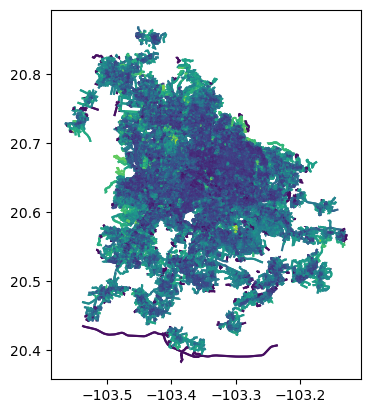

In [72]:
edges.plot("ndvi_mean")

In [59]:
edges.drop(columns="geometry").to_json("edges_ndvi.json", orient="records", lines=True)

In [60]:
edges.to_file("edges_with_ndvi.shp")

In [61]:
edges.to_file("edges_with_ndvi.geojson", driver="GeoJSON")

## Pendientes

In [ ]:
schema = 'osmnx'
table = 'edges_elevation_23_line'
pendiente = "grade_abs"
u = "u"
v = "v"
k = "key"

query = f"""
SELECT {pendiente}, {u}, {v}, {k}, geometry
FROM {schema}.{table}
"""

intt_gdl = aup.gdf_from_query(query, geometry_col="geometry")
intt_gdl.head(10)

## Uso de suelo

In [11]:
print(predios['clasificacion_uso_suelo'].unique())

['ComercialServicios' 'Residencial' 'Mixto' 'Equipamiento'
 'Complementarios' 'Industrial']


In [8]:
edges_buffer = edges_var.copy()
edges_buffer['geometry'] = edges_buffer.buffer(30)

In [9]:
# Cargar datos
land_use = gpd.read_file("predios_uso_suelo.geojson")

# Convertir a coordenadas proyectadas para cálculos espaciales
land_use = land_use.to_crs('epsg:32613')
edges_buffer = edges_buffer.to_crs('epsg:32613')

# Filtrar solo los polígonos de uso de suelo Residencial
land_use_residencial = land_use[land_use['clasificacion_uso_suelo'].isin(['Residencial', 'Mixto'])]

# Calcular intersecciones solo con uso de suelo Residencial
intersections_residencial = gpd.overlay(edges_buffer, land_use_residencial, how='intersection')

# Mostrar las primeras filas
intersections_residencial.head()


,u,v,key,osmid,grade_abs,clasificacion_uso_suelo,geometry
0,9342184105,1793387649,0,167542247,0.000,Residencial,"POLYGON ((664124.696 2281984.683, 664123.807 2..."
1,1793387649,1660016550,0,127108560,0.013,Residencial,"POLYGON ((664138.500 2281987.153, 664119.820 2..."
2,1793387649,9342184105,0,167542247,0.000,Residencial,"POLYGON ((664124.696 2281984.683, 664123.807 2..."
3,1686407311,1394426259,0,127108581,0.010,Residencial,"POLYGON ((664131.897 2281991.295, 664134.410 2..."
4,1407606527,1793387649,0,127108560,0.017,Residencial,"POLYGON ((664124.617 2281984.388, 664123.699 2..."


In [10]:
if len(intersections_residencial) == 0:
    print("No hay intersecciones. Verifica las geometrías y los CRS.")
else:
    # Calcular el área de intersección
    intersections_residencial['area_inte'] = intersections_residencial.geometry.area

    # Sumar el área de intersección por cada segmento de calle
    area_usos_edges = intersections_residencial.groupby(['u', 'v', 'key'])['area_inte'].sum()

    # Calcular la proporción de cada uso de suelo
    land_use_presence_edges = intersections_residencial.groupby(['u', 'v', 'key', 'clasificacion_uso_suelo'])['area_inte'].sum()
    percentage_land_use_edges = land_use_presence_edges / area_usos_edges

    print("Número de intersecciones:", len(intersections_residencial))
    print("Número de calles únicas con intersecciones:", intersections_residencial[['u', 'v', 'key']].nunique())

    # Calcular el número de categorías por calle
    n_land_use = intersections_residencial.groupby(['u', 'v', 'key'])['clasificacion_uso_suelo'].unique().apply(len)

    # Aplicar la fórmula de entropía de Shannon
    def calcular_entropia(osmid, percentage_series):
        if osmid not in percentage_series.index or len(percentage_series.loc[osmid]) == 1:
            return 0  # Sin datos o solo un uso → entropía 0

        probs = percentage_series.loc[osmid].values
        return -np.sum(probs * np.log2(probs))

    edges_buffer['entropy'] = edges_buffer.set_index(['u', 'v', 'key']).index.map(
        lambda idx: calcular_entropia(idx, percentage_land_use_edges))

    # Convertir a CRS original y guardar resultado
    edges_buffer['buffer_wkt'] = edges_buffer['geometry'].apply(lambda geom: geom.wkt)   

Número de intersecciones: 3260232
Número de calles únicas con intersecciones: u      70478
v      70441
key        3
dtype: int64


In [16]:
print(edges_buffer['entropy'].unique())

[0.         0.23462849 0.69200725 ... 0.92144849 0.22871117 0.99166739]


In [12]:
edges_buffer

,u,v,key,osmid,grade_abs,geometry,entropy,buffer_wkt
0,1774344156,1827050267,0,782694623,0.014,"POLYGON ((675029.493 2274948.170, 675028.020 2...",0.0,"POLYGON ((675029.4927592592 2274948.170386933,..."
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"POLYGON ((674909.825 2275036.735, 674907.265 2...",0.0,POLYGON ((674909.8247008597 2275036.7351409537...
2,1774344156,4677618217,0,473698618,0.034,"POLYGON ((675100.162 2275027.270, 675102.779 2...",0.0,"POLYGON ((675100.162103643 2275027.270349188, ..."
3,1774344156,1827050277,0,782694623,0.012,"POLYGON ((675039.229 2275109.244, 675040.538 2...",0.0,"POLYGON ((675039.229048314 2275109.2439526436,..."
4,1827050267,1774344156,0,782694623,0.014,"POLYGON ((675008.086 2275037.765, 675009.558 2...",0.0,"POLYGON ((675008.0855375683 2275037.764706361,..."
...,...,...,...,...,...,...,...,...
414587,1390347431,1611189558,0,911043965,0.000,"POLYGON ((677653.994 2287498.065, 677656.819 2...",0.0,"POLYGON ((677653.993798156 2287498.0651871366,..."
414588,1390347431,4788435703,0,826248523,0.000,"POLYGON ((677644.838 2287385.891, 677644.046 2...",0.0,POLYGON ((677644.8384138402 2287385.8910745597...
414589,1611189448,1390347438,0,825936604,0.000,"POLYGON ((677572.637 2287224.490, 677569.759 2...",0.0,POLYGON ((677572.6373779246 2287224.4898589705...
414590,1611189448,1611189558,0,911043964,0.004,"POLYGON ((677589.666 2287349.039, 677617.689 2...",0.0,POLYGON ((677589.6663720611 2287349.0390375964...


## Sidewalks

In [15]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [16]:
query = f"SELECT * FROM censo_urbano.censo_fm_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
sidewalks = aup.gdf_from_query(query, geometry_col='geometry')
print(sidewalks.shape)
sidewalks.head(4)

(261012, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,3,3,3,3,3,3,1,11,0
1,1412000013185020,14,120,0001,3185,020,07967,00001,6,Ninguno,...,3,3,1,3,3,3,3,1,11,0
2,1412000011850003,14,120,0001,1850,003,04876,00008,4,Trafalgar,...,3,1,1,3,3,3,1,1,11,0
3,1412000011850006,14,120,0001,1850,006,07991,00001,3,Pasamontes,...,3,1,3,3,3,3,1,1,11,0


In [17]:
edges_buffer = edges_var.copy()
edges_buffer['geometry'] = edges_buffer.buffer(30)

In [18]:
# Convertir a CRS proyectado (UTM)
sidewalks = sidewalks.to_crs('EPSG:32613')

In [ ]:
# Calcular intersecciones entre buffers y aceras
sidewalks['geometry'] = sidewalks.simplify(tolerance=1.0)
edges_buffer['geometry'] = edges_buffer.simplify(tolerance=1.0)
intersections = sidewalks.overlay(edges_buffer, how='intersection')

In [ ]:
if intersections.empty:
    print("No hay intersecciones. Saltando...")
    edges['sidewalk'] = 0  
else:
    #intersections['edge_index'] = intersections.sindex.nearest(edges.sindex, return_all=False)[0]  # Asegura coincidencia
    intersections["length"] = intersections.length
    length_with_sidewalks = intersections[['u','v','key','BANQUETA','length']].groupby(['u','v','key','BANQUETA']).sum()
    length_with_sidewalks = length_with_sidewalks.reset.index()
    lenght_with_sidewalks.head(2)

## Densidad a edges

In [9]:
nodes_id = edges_var.v.unique().tolist()
u = edges_var.u.unique().tolist()
nodes_id.extend(u)
myset = set(nodes_id)
nodes_id = list(myset)
schema = 'censo'
nodes_folder = 'pobcenso_inegi_20_mzaageb_node'
nodes_query = f"SELECT * FROM {schema}.{nodes_folder} WHERE osmid IN {str(tuple(nodes_id))}"
nodes_pop = aup.gdf_from_query(nodes_query, geometry_col="geometry", index_col="osmid")

In [11]:
voronoi = gpd.read_file('/home/jovyan/accesibilidad-urbana/data/external/Guadalajara_script22_voronoipolys.gpkg')
voronoi = voronoi.to_crs("EPSG:32613")
voronoi['area_ha'] = voronoi.area/10000

In [10]:
nodes_pop = nodes_pop.merge(voronoi[['osmid','area_ha']],
                           on='osmid', how='left')
print(nodes_pop.shape)
nodes_pop.head(2)

(160318, 45)


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,city,area_ha
0,28751344,POINT (-103.30631 20.71153),74.890169,39.475573,35.414596,4.052830,2.794774,1.258056,3.547978,2.176828,...,55.442126,28.343083,27.099043,16.518011,52.241580,6.130578,2.055585,155.402389,Guadalajara,0.486014
1,28753224,POINT (-103.31665 20.70065),180.215453,94.978818,85.236635,4.968364,3.053272,1.915092,6.664361,2.904487,...,134.938995,71.333002,63.605993,35.514429,119.215103,25.485921,5.448743,245.808088,Guadalajara,0.739377


In [12]:
nodes_pop['dens'] = nodes_pop['pobtot'] / nodes_pop['area_ha']

In [13]:
matched_osmid = nodes_pop['osmid'].isin(voronoi['osmid'])
print(f"Coincidencias de osmid: {matched_osmid.sum()} / {len(nodes_pop)}")

Coincidencias de osmid: 160318 / 160318


In [14]:
edges_var = edges_var.merge(nodes_pop[['osmid','dens']],
                           left_on='u', right_on='osmid',
                           how='left',
                           suffixes=('_edge', '_node'))
edges_var = edges_var.rename(columns={'dens':'dens_u'})
edges_var.head(2)

,u,v,key,osmid_edge,grade_abs,geometry,osmid_node,dens_u
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",1.774344e+09,67.525184
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",1.774344e+09,67.525184


In [15]:
edges_var = edges_var.merge(nodes_pop[['osmid','dens']],
                           left_on='v', right_on='osmid',
                           how='left',
                           suffixes=('_edges', '_nodes'))
edges_var = edges_var.rename(columns={'dens':'dens_v'})
edges_var.head(2)

,u,v,key,osmid_edge,grade_abs,geometry,osmid_node,dens_u,osmid,dens_v
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",1.774344e+09,67.525184,1.827050e+09,80.805215
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",1.774344e+09,67.525184,6.511606e+09,54.953020


In [17]:
edges_var['dens'] = edges_var[['dens_u','dens_v']].mean(axis=1)
print(edges_var.shape)
edges_var.head(2)

(414592, 11)


,u,v,key,osmid_edge,grade_abs,geometry,osmid_node,dens_u,osmid,dens_v,dens
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",1.774344e+09,67.525184,1.827050e+09,80.805215,74.165200
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",1.774344e+09,67.525184,6.511606e+09,54.953020,61.239102


In [16]:
edges_var.columns

Index(['u', 'v', 'key', 'osmid_edge', 'grade_abs', 'geometry', 'osmid_node',
       'dens_u', 'osmid', 'dens_v'],
      dtype='object')

In [59]:
edges_var = edges_var.drop(columns=['osmid'], errors='ignore')

In [60]:
edges_var = edges_var.rename(columns={'osmid_x': 'osmid_u', 'osmid_y': 'osmid_v',
                                      'dens_x': 'dens_u', 'dens_y': 'dens_v'})


In [18]:
edges_var.to_file("Density_to_edges.geojson", driver="GeoJSON", errors='ignore')

## Densidad poblacional

In [12]:
nodespob = nodes_pop.merge(
    voronoi[['osmid', 'area_ha']],  # Selecciona solo las columnas necesarias de voronoi_gdf
    on='osmid',
    how='left'
    )

# Verifica las primeras filas para asegurarte de que el merge se realizó correctamente
nodespob.head(3)

,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,city,area_ha
0,28751344,POINT (-103.30631 20.71153),74.890169,39.475573,35.414596,4.052830,2.794774,1.258056,3.547978,2.176828,...,55.442126,28.343083,27.099043,16.518011,52.241580,6.130578,2.055585,155.402389,Guadalajara,0.486014
1,28753224,POINT (-103.31665 20.70065),180.215453,94.978818,85.236635,4.968364,3.053272,1.915092,6.664361,2.904487,...,134.938995,71.333002,63.605993,35.514429,119.215103,25.485921,5.448743,245.808088,Guadalajara,0.739377
2,28757751,POINT (-103.30736 20.70853),58.046111,30.809445,27.236666,2.264263,1.294463,0.969800,2.744622,1.903764,...,40.472681,20.763925,19.708756,14.490449,37.168716,6.386946,2.730570,57.898034,Guadalajara,1.011087


In [19]:
edges_with_u = edges_var.merge(edges[['u', 'v', 'key']], on=['u', 'v'], how='left')
edges_with_u.head(2)

,u,v,key_x,osmid,grade_abs,geometry,key_y
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",0
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",0


In [20]:
edges_with_u.drop(columns = "key_x", inplace = True)
edges_with_u.rename(columns = {"key_y" : "key"}, inplace = True)

In [21]:
# Combinar para obtener los datos del nodo de origen 'u'
edges_with_u = edges_with_u.merge(
    nodespob[['osmid', 'pobtot', 'area_ha', "geometry"]], 
    left_on='u',  # Unir usando la columna 'u' de edges
    right_on='osmid',  # Une con la columna 'osmid' de nodes_gdf
    how='left',
    suffixes = ("_edge", "_node")
).rename(columns={'pobtot': 'pobtot_u', 'area_ha': 'area_ha_u'})  # Renombra columnas para evitar conflictos

# Combinar para obtener los datos del nodo de destino 'v'
edges_with_uv = edges_with_u.merge(
    nodespob[['osmid', 'pobtot', 'area_ha', "geometry"]], 
    left_on='v', # Unir usando la columna 'v' de edges
    right_on='osmid',  # Unir con la columna 'osmid' de nodes_gdf
    how='left',  # Mantiene todas las filas de edges_with_u
    suffixes = ("_edge", "_node")
).rename(columns={'pobtot': 'pobtot_v', 'area_ha': 'area_ha_v'})  # Renombra columnas para evitar conflictos

In [22]:
edges_with_uv.columns

Index(['u', 'v', 'osmid_edge', 'grade_abs', 'geometry_edge', 'key',
       'osmid_node', 'pobtot_u', 'area_ha_u', 'geometry_node', 'osmid',
       'pobtot_v', 'area_ha_v', 'geometry'],
      dtype='object')

In [23]:
# Calcular la densidad de cada nodo
edges_with_uv['density_u'] = edges_with_uv['pobtot_u'] / edges_with_uv['area_ha_u']
edges_with_uv['density_v'] = edges_with_uv['pobtot_v'] / edges_with_uv['area_ha_v']
edges_with_uv["average_population"] = (edges_with_uv['pobtot_u'] + edges_with_uv['pobtot_v']) / 2
edges_with_uv["total_pobtot"] = edges_with_uv['pobtot_u'] + edges_with_uv['pobtot_v']

# Calcular la densidad promedio para cada arista (promedio de los nodos u y v)
edges_with_uv['average_density'] = (edges_with_uv['density_u'] + edges_with_uv['density_v']) / 2

In [31]:
edges_with_uv = edges_with_uv[['u', 'v', "key", 'density_u', 'density_v', 'average_density', "average_population", "total_pobtot", "geometry_edge"]]
edges_with_uv.rename(columns = {"geometry_edge" : "geometry"}, inplace = True)
edges_with_uv.head()

,u,v,key,density_u,density_v,average_density,average_population,total_pobtot,geometry
0,1774344156,1827050267,0,67.525184,80.805215,74.165200,52.435167,104.870334,"LINESTRING (675034.767 2275024.049, 675002.812..."
1,1774344156,6511605645,0,67.525184,54.953020,61.239102,38.120943,76.241885,"LINESTRING (675034.767 2275024.049, 674919.897..."
2,1774344156,4677618217,0,67.525184,148.872395,108.198790,57.917122,115.834244,"LINESTRING (675034.767 2275024.049, 675087.745..."
3,1774344156,1827050277,0,67.525184,51.738733,59.631959,27.279865,54.559731,"LINESTRING (675034.767 2275024.049, 675066.723..."
4,1827050267,1774344156,0,80.805215,67.525184,74.165200,52.435167,104.870334,"LINESTRING (675002.812 2274961.886, 675034.767..."


In [32]:
if 'geometry' in edges_with_uv.columns:
    edges_with_uv = gpd.GeoDataFrame(edges_with_uv, geometry='geometry') 

    edges_with_uv.to_file("Poblational_density.geojson", driver="GeoJSON")
else:
    print("Error: El DataFrame no tiene una columna 'geometry'.")